In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from skimage import draw

In [2]:
# approximation
UPPER_BOUNDS_CAM1 = [[110,150], [95,175],
                     [90,200], [85,225], [82,250], [80,275], 
                     [78,300], [75,325], [73,350], [73,375],
                     [72,400], [71,425], [71,450], [71,475],
                     [70,500], [70,525], [70,550], [70,575],
                     [70,600], [70,625], [70,650], [70,675],
                     [70,700], [70,725], [70,750], [70,775],
                     [75,800], [73,825], [75,850], [76,875],
                     [77,900], [78,925], [78,950], [81,975],
                     [82,1000], [88,1025], [94,1050], 
                     [100,1075], [100,1100], [120,1125]]

UPPER_BOUNDS_CAM3 = [[845,150], [845,175],
                     [840,200], [835,225], [827,250], [819,275], 
                     [805,300], [790,325], [775,350], [750,375],
                     [730,400], [710,425], [690,450], [665,475],
                     [630,500], [600,525], [560,550], [550,575],
                     [505,600], [400,625], [380,650], [380,675],
                     [380,700], [380,725], [380,750], [380,775],
                     [380,800], [380,825], [380,850], [380,875],
                     [380,900], [380,925], [380,950], [380,975],
                     [380,1000], [380,1025], [380,1050], [380,1075], 
                     [380,1100]]
'''
UPPER_BOUNDS_CAM3 = [[730,400], [710,425], [690,450], [665,475],
                     [630,500], [600,525], [560,550], [550,575],
                     [505,600], [400,625], [380,650], [380,675],
                     [380,700], [380,725], [380,750], [380,775],
                     [380,800], [380,825], [380,850], [380,875],
                     [380,900]]
'''

UPPER_BOUNDS_CAM1 = np.array(UPPER_BOUNDS_CAM1)
UPPER_BOUNDS_CAM3 = np.array(UPPER_BOUNDS_CAM3)

In [3]:
# filename is an image file
def preprocess_image(filename):
    bgr_image       = cv2.imread(filename)
    bgr_image       = increase_brightness(bgr_image, value=35)
    rgb_image       = cv2.cvtColor(bgr_image, cv2.COLOR_BGR2RGB)
    gray_image      = cv2.cvtColor(rgb_image, cv2.COLOR_RGB2GRAY)
    _, binary_image = cv2.threshold(gray_image, 220, 255, cv2.THRESH_BINARY)
    binary_image    = binary_image/255
    
    return binary_image, rgb_image

In [4]:
def increase_brightness(img, value=30):
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    h, s, v = cv2.split(hsv)

    lim = 255 - value
    v[v > lim] = 255
    v[v <= lim] += value

    final_hsv = cv2.merge((h, s, v))
    img = cv2.cvtColor(final_hsv, cv2.COLOR_HSV2BGR)
    return img

In [5]:
# points is a starting coordinate --> [y,x]
# this function is used in inversed_hieghts() function
def count_pixel(binary_image, points):
    y = points[0]
    x = points[1]
    no_of_pixels = 0
    
    while binary_image[y,x] == 1:
        y += 1
        no_of_pixels += 1
    
    return no_of_pixels

In [6]:
# count_pixel() counts the pixels using top-down approach
# 1 points at a time
# inversed_heights() repeats count_pixel() many times
def inversed_heights(binary_image, starting_points):
    heights = []
    for points in starting_points:
        height = count_pixel(binary_image, points)
        heights.append(height)
    
    return np.array(heights)

In [7]:
# determine the actual boundary location
def find_boundary_coords(inversed_height_points, upper_bounds):
    y_locs = upper_bounds[:,0] + inversed_height_points
    x_locs = upper_bounds[:,1]
    
    y_locs = y_locs[:,np.newaxis]
    x_locs = x_locs[:,np.newaxis]
    
    coords = np.hstack((y_locs, x_locs))
    
    return coords

In [8]:
# calculates the actual water height
# (container_height - inversed_height)
def actual_height(inversed_height):
    return 302-inversed_height

In [9]:
def pixel_to_mm(value):
    return value*0.828

In [10]:
def line_indices(boundary_coords):
    rrs = []
    ccs = []
    for i in range(len(boundary_coords)-1):
        y0 = boundary_coords[i][0]
        x0 = boundary_coords[i][1]
        y1 = boundary_coords[i+1][0]
        x1 = boundary_coords[i+1][1]
        
        rr, cc, _ = draw.line_aa(y0, x0, y1, x1)
        rrs.append(rr)
        ccs.append(cc)
    
    return rrs, ccs

In [11]:
def draw_lines(rgb_image, rrs, ccs):
    for rr, cc in zip(rrs, ccs):
        rgb_image[rr,cc,0] = 0
        rgb_image[rr,cc,1] = 0
        rgb_image[rr,cc,2] = 255
        
        rgb_image[rr+1,cc+1,0] = 0
        rgb_image[rr+1,cc+1,1] = 0
        rgb_image[rr+1,cc+1,2] = 255
    
    return rgb_image

# Main program goes below

In [12]:
binary_image, rgb_image = preprocess_image('cam3_images/CCFL040_10_2000_335_up_a_0003.bmp')

In [13]:
heights = inversed_heights(binary_image, UPPER_BOUNDS_CAM3)

In [14]:
boundary_coords = find_boundary_coords(heights, UPPER_BOUNDS_CAM3)

In [15]:
rrs, ccs = line_indices(boundary_coords)

In [16]:
rgb_image_with_line = draw_lines(rgb_image, rrs, ccs)

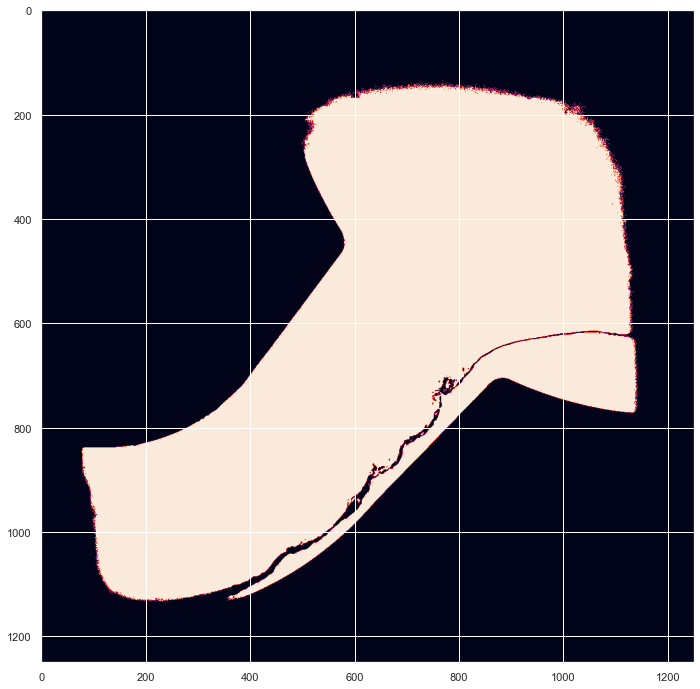

In [17]:
plt.figure(figsize=(12,12))
plt.imshow(binary_image)

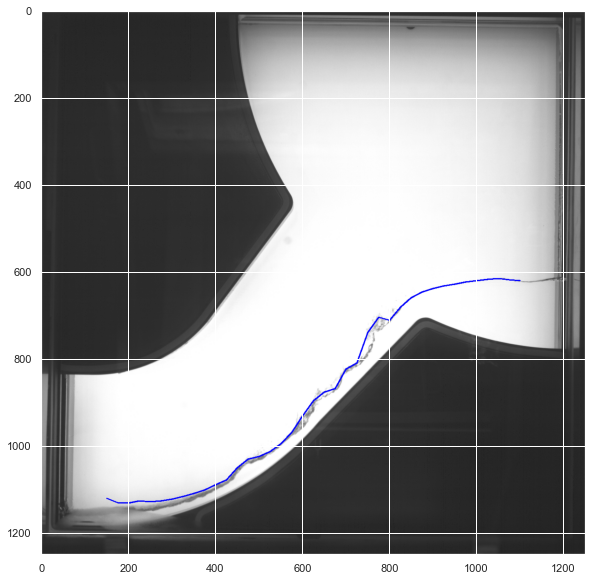

In [18]:
plt.figure(figsize=(10,10))
plt.imshow(rgb_image_with_line)